# Vehicle Detection

In [2]:
# Load relevant modules
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
import glob

from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Step 0: Load data

In [3]:
# Define helper functions for data loading
def loadData(dataPath,labelValue):
    imgTemp = []
    folderList = glob.glob(dataPath)
    for folder in folderList:
        path = folder + '/*.png'
        imgList = glob.glob(path)
        for imgPath in imgList:
            img = cv2.imread(imgPath)
            # Convert color space from BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            imgTemp.append(img)
    X = np.array(imgTemp)
    Y = labelValue*np.ones(X.shape[0],dtype = np.int8)
    print('Dimension of pictures = ' + str(X.shape))
    print('Dimension of labels = ' + str(Y.shape))
    return X, Y

def loadTestData(dataPath):
    imgTemp = []
    imgList = glob.glob(dataPath)
    for imgPath in imgList:
        img = cv2.imread(imgPath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgTemp.append(img)
    X = np.array(imgTemp)
    print('Number of test images = ' + str(X.shape[0]))
    return X

In [17]:
# Define helper function to plot original images
def plotExample(imgCar,imgNonCar,idx):
    n = len(idx)
    fig = plt.figure(figsize=(12,4))
    for i in range(n):
        ax = fig.add_subplot(2, n, i+1)
        plt.imshow(imgCar[idx[i]].squeeze())
#         plt.title('Image of cars')
        ax = fig.add_subplot(2, n, i+n+1)
        plt.imshow(imgNonCar[idx[i]].squeeze())
#         plt.title('Image of non-car objects')
    plt.show()
    return fig

In [5]:
# Load training & validation data
imgCar,labelCar = loadData('data/train_vehicles/*',1.0)
imgNonCar,labelNonCar = loadData('data/train_nonVehicles/*',0.0)

Dimension of pictures = (8792, 64, 64, 3)
Dimension of labels = (8792,)
Dimension of pictures = (8968, 64, 64, 3)
Dimension of labels = (8968,)


In [6]:
# Load testing data
imgTest = loadTestData('data/test/*')

Number of test images = 6


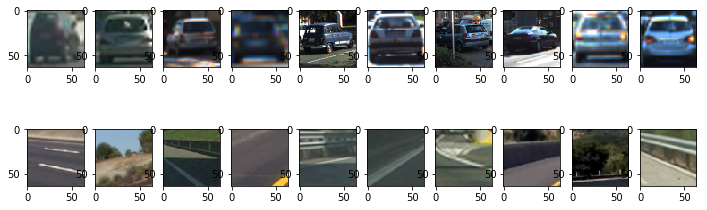

In [18]:
# Plot examples
demoIdx = np.random.randint(0, 8000, 10)

fig = plotExample(imgCar,imgNonCar,demoIdx)
fig.savefig('figures/dataDemo.png',bbox_inches='tight')

## Step 1: Extract features and train classifier

### a. Extract features (HOG and Color features)

In [139]:
# Define parameters
# Group of pixels forms cell, group of cells forms block. One block means one box in the 
# sliding window search, and blocks can overlap

# dimInput = dimension of training images, number of pixels
# nGrad = number of gradient for each cell
# nPix = number of pixels in each cell

opt = {'dimInput':64, 'HogImg': False,
       'nGrad': 16, 'nPix': 8, 'nCell':2, 'cellPerStep':2,
       'cSpace':'YCrCb','nBin':32, 'binRange':(0,256), 'heatAvgTh':0.8, 'heatSingleTh':1}


In [10]:
# Define helper functions for feature extraction
def hogFeature(x, nGrad, nPix, nCell):
    if opt['HogImg'] == False:
        hogF = hog(x, orientations = nGrad, pixels_per_cell = (nPix, nPix),
                  cells_per_block = (nCell, nCell), transform_sqrt = False, 
                  visualise = False, feature_vector = False)
        return hogF
    else:
        hogF, hogImg = hog(x, orientations = nGrad, pixels_per_cell = (nPix, nPix),
                   cells_per_block = (nCell, nCell), transform_sqrt = False, 
                   visualise = True, feature_vector = False)
        return hogF, hogImg

def hocFeature(x, nBin = 32, binRange = (0, 256)):
    histCh1 = np.histogram(x[:,:,0], bins = nBin, range = binRange)
    histCh2 = np.histogram(x[:,:,1], bins = nBin, range = binRange)
    histCh3 = np.histogram(x[:,:,2], bins = nBin, range = binRange)
    xOut = np.concatenate((histCh1[0], histCh2[0], histCh3[0]))
    return xOut

def extractSingleFeature(x, opt):
    dimInput = opt['dimInput']
    cSpace = opt['cSpace']
    nGrad = opt['nGrad']
    nPix = opt['nPix']
    nCell = opt['nCell']
    nBin = opt['nBin']
    binRange = opt['binRange']  
    hogF,hocF,xCvt,xFeature = [],[],[],[]
    hogImg = []
    # convert color space
    xCvt = cv2.cvtColor(x, getattr(cv2, 'COLOR_RGB2' + cSpace))
    # extract gradient features
    for j in range(xCvt.shape[2]):
        if opt['HogImg'] == False:
            hogF.append(hogFeature(xCvt[:,:,j], nGrad, nPix, nCell))
        else:
            hogFTemp,hogImgTemp = (hogFeature(xCvt[:,:,j], nGrad, nPix, nCell))
            hogF.append(hogFTemp)
            hogImg.append(hogImgTemp)
    hogF = np.ravel(hogF)
    hocF = hocFeature(xCvt, nBin, binRange)
    xFeature = np.concatenate((hogF,hocF))
    
    if opt['HogImg'] == False:
        return xFeature
    else:
        return xFeature, hogImg

def extractFeature(X, opt):
    print("Extracting features from data....")
    timeStart = time.time()
    XOut = []
    # extract features
    for x in X:
        xFeature = extractSingleFeature(x,opt)
        XOut.append(xFeature)
    timeElapsed = time.time() - timeStart
    print("Extraction finished, time used = %.1f sec" % (timeElapsed))
    return XOut

In [11]:
# Define helper functions to mix and split features
def mixData(X1,X2,Y1,Y2):
    X = np.append(X1, X2, axis = 0)
    Y = np.append(Y1, Y2, axis = 0)
    print('Size of total data = ' + str(X.shape))
    return X,Y

def splitData(X, Y):
    randState = 123
    XTrain, XTest, YTrain, YTest = train_test_split(
    X, Y, test_size=0.25, random_state=randState)
    print('Size of training data = ' + str(XTrain.shape))
    print('Size of validation data = ' + str(XTest.shape))
    return XTrain,XTest,YTrain,YTest

In [12]:
# Convert images into feature space
XCar = extractFeature(imgCar, opt)
XNonCar = extractFeature(imgNonCar, opt)

# Mix features matrices of car and noncar
XTotal, YTotal = mixData(XCar, XNonCar, labelCar, labelNonCar)

# Scale features
X_scaler = StandardScaler().fit(XTotal)
XScaled = X_scaler.transform(XTotal)

# Split features into training and validation sets
# Dimension = (number of examles, dimension of features)
XTrain, XValid, YTrain, YValid = splitData(XScaled,YTotal)

Extracting features from data....
Extraction finished, time used = 54.1 sec
Extracting features from data....
Extraction finished, time used = 52.7 sec
Size of total data = (17760, 9504)
Size of training data = (13320, 9504)
Size of validation data = (4440, 9504)


In [13]:
def plotFeature(img, savePath):
    opt['HogImg'] = True
    x, hogImg = extractSingleFeature(img, opt)
    xScaled = X_scaler.transform(x)
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original image', fontsize=16)
    ax2.imshow(hogImg[0])
    ax2.set_title('Hog features', fontsize=16)
    ax3.plot(xScaled)
    ax3.set_title('Hog + color features (flattened)', fontsize=16)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    f.savefig(savePath)
    return fig

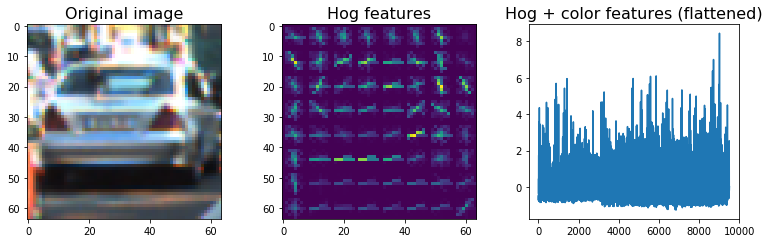

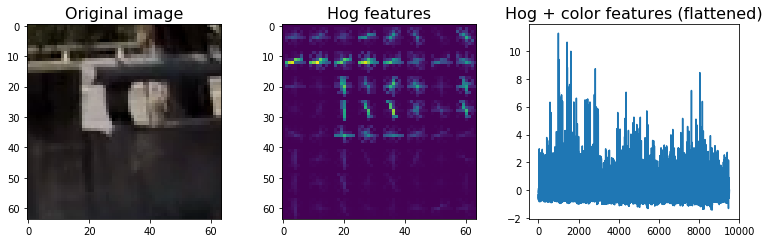

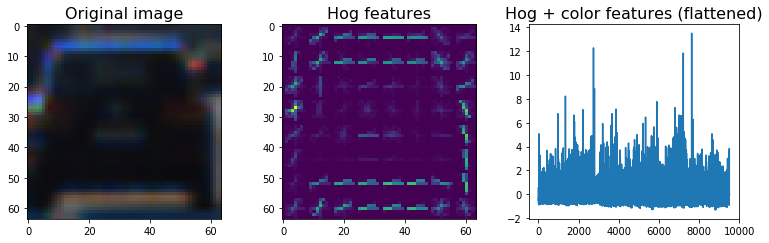

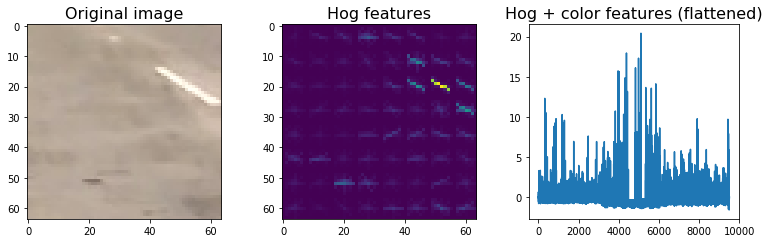

In [14]:
# demoIdx = np.random.randint(0, 8000,10)
demoIdx = [2842, 3108]

for idx in demoIdx:
    savePath1 = str('figures/featureCar' + str(idx) + '.png')
    savePath2 = str('figures/featureNonCar' + str(idx) + '.png')
    plotFeature(imgCar[idx], savePath1)
    plotFeature(imgNonCar[idx], savePath2)

### b. Train classifier

In [19]:
# Choose classifier, the  linear SVC classifier is chosen
clf = LinearSVC()

In [20]:
# Train and validate classifier
t1 = time.time()
print('Training of classifier starts...')
clf.fit(XTrain, YTrain)
print('Training ends. Training time = %.1f sec' % (time.time()-t1))
print('Validation accuracy = %.1f %%' % (100*clf.score(XValid,YValid)))

Training of classifier starts...
Training ends. Training time = 30.2 sec
Validation accuracy = 99.2 %


## Step 2: Sliding window search

In [73]:
# Define a function to draw bounding boxes
def scanImg(img, regionBound, scale, X_scaler, clf, boxes, opt):
    # Unpack parameters
    dimInput = opt['dimInput']
    cSpace = opt['cSpace']
    nGrad = opt['nGrad']
    nPix = opt['nPix']
    nCell = opt['nCell']
    cellPerStep = opt['cellPerStep']
    nBin = opt['nBin']
    binRange = opt['binRange']
    
    # Cut regions of interested in the image
    x1B = regionBound[0,0]
    y1B = regionBound[0,1]
    x2B = regionBound[1,0]
    y2B = regionBound[1,1]
    
    imgRegion = img[y1B:y2B, x1B:x2B, :]
    imgRegion = cv2.cvtColor(imgRegion, getattr(cv2, 'COLOR_RGB2' + cSpace))
    imgShapeOri = imgRegion.shape
    # scale image
    imgRegion = cv2.resize(imgRegion, 
                           (np.int(imgShapeOri[1]/scale), np.int(imgShapeOri[0]/scale)))
    imgShape = imgRegion.shape
    # Define blocks and steps
    # number of blocks along image region
    nxblocks = (imgShape[1] // nPix) - nCell + 1
    nyblocks = (imgShape[0] // nPix) - nCell + 1
    # number of features per block
    nfeat_per_block = nGrad*nCell**2
    # number of blocks per search window
    nblocks_per_window = (dimInput // nPix) - nCell + 1
    # number of cells will moved during window sliding
    cells_per_step = 2
    # number of windows/boxes along image region
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    # Comput HOG feature for image region
    hog1 = hogFeature(imgRegion[:,:,0], nGrad, nPix, nCell)
    hog2 = hogFeature(imgRegion[:,:,1], nGrad, nPix, nCell)
    hog3 = hogFeature(imgRegion[:,:,2], nGrad, nPix, nCell)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cellPerStep
            xpos = xb*cellPerStep
            xleft = xpos*nPix
            ytop = ypos*nPix
            
            # Extract HOG for this patch
            hogF1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hogF2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hogF3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hogF = np.hstack((hogF1, hogF2, hogF3))
            # Extract the image patch and color feature
            imgPatch = cv2.resize(imgRegion[ytop:ytop+dimInput, xleft:xleft+dimInput],
                                  (dimInput,dimInput))
            hocF = hocFeature(imgPatch, nBin, binRange)
            # Scale features and make a prediction
            x_features = X_scaler.transform(np.hstack((hogF, hocF)).reshape(1, -1))    
            y_pred = clf.predict(x_features)

            # Save boxes if return positive detection
            if y_pred == 1:
                boxDim = np.int(dimInput*scale)
                # Coordinate of upper left corner of box
                x1 = np.int(xleft*scale) + x1B
                y1 = np.int(ytop*scale) + y1B
                # Coordinate of bottom right corner of box
                x2 = x1 + boxDim
                y2 = y1 + boxDim
                # Append box position to list
                boxes.append(((x1, y1), (x2, y2)))
    return boxes

In [74]:
# Define helper functions to visulize intermidiate result
def drawBoxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def drawRegionBounds(img, regionBounds, color=(0, 255, 0), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for regionBound in regionBounds:
        # Draw a rectangle given bbox coordinates
        box = tuple(map(tuple, regionBound))
        cv2.rectangle(imcopy, box[0], box[1], (0,255,0), thick)
    # Return the image copy with boxes drawn
    return imcopy

In [75]:
# Define pipeline to test sliding window
def pipelineSlideWin(img):
    boxes = []
    # Collect positive detections
    for regionBound, boxScale in zip(regionBounds, boxScales):
        boxes = scanImg(img, regionBound, boxScale, X_scaler, clf, boxes, opt)
    # Draw boxes
    imgOut = drawBoxes(img, boxes, color=(255, 0, 0), thick = 2)
    # Draw bounds
    imgOut = drawRegionBounds(imgOut, regionBounds, color=(0, 255, 0), thick = 6)
    return imgOut

In [76]:
# Define helper function to plot detection process
def plotSlideWin(img, imgOut, savePath):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original image', fontsize=16)
    ax2.imshow(imgOut)
    ax2.set_title('Sliding window search', fontsize=16)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    f.savefig(savePath)
    return fig

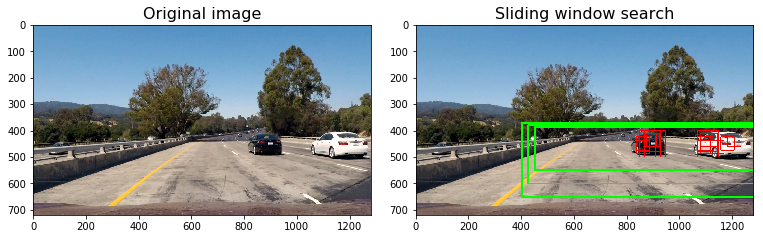

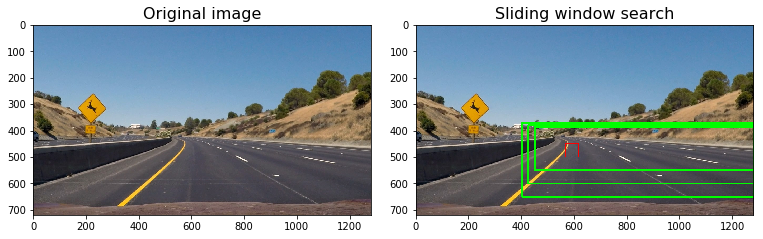

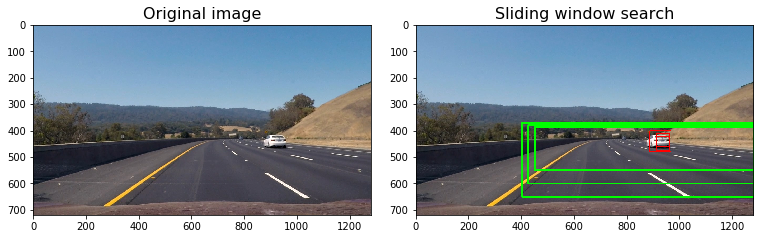

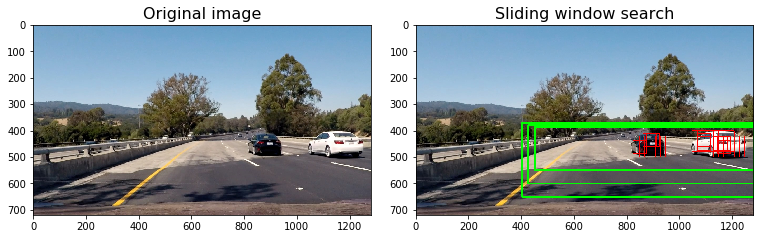

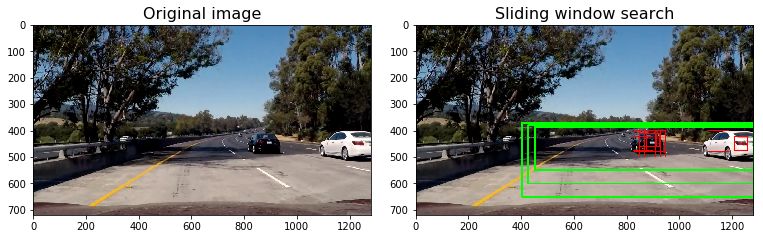

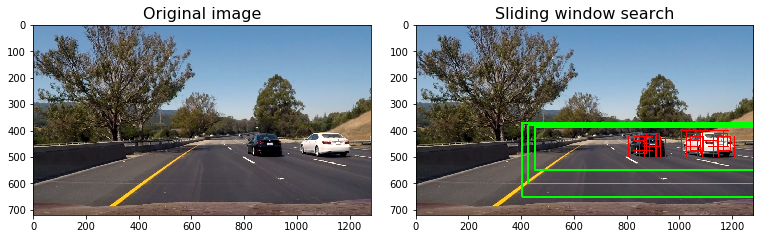

In [158]:
# Define the region bounds for search windows and size of sliding windows
# Coornidate of image region [(x1,y1),(x2,y2)], from bottom to top
regionBounds = np.array(([[[400,370],[1280,650]],
                          [[425,380],[1280,600]],
                          [[450,385], [1280,550]]]))

# Define scales of boxes, from bottom to top
# orginal size = nPix*nCell, < 1 means shrinking, > 1 means enlarge 
boxScales = [3, 1.25, 0.8]
# boxScales = [3, 0.8]

# Set parameter
opt['HogImg'] = False

# Test sliding windows on testing imgages
i = 0
for img in imgTest:
    savePath = str('figures/slideWin' + str(i) + '.png')
    imgOut = pipelineSlideWin(img)
    plotSlideWin(img, imgOut, savePath)
    i += 1

## Step 3: Video Implementation

### a. Build pipeline for single image

In [184]:
# Initialize parameters
opt['heatSingleTh'] = 1

In [173]:
def createHeatMap(heatMap, boxes, opt):
    for box in boxes:
        heatMap[box[0][1]:box[1][1],box[0][0]:box[1][0]] += 1
    heatMap[heatMap <= opt['heatSingleTh']] = 0
    return heatMap

def heatToDetection(heatMap):
    labels = []
    labels = label(heatMap)
    return labels

def drawDetection(img, labels):
    # make a copy of the image
    imgOut = np.copy(img)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(imgOut, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return imgOut

In [117]:
# Define pipeline to process test images
def pipelineImage(img):
    boxes = []
    # Collect positive detections
    for regionBound, boxScale in zip(regionBounds, boxScales):
        boxes = scanImg(img, regionBound, boxScale, X_scaler, clf, boxes, opt)
    # Draw boxes
    imgOut = drawBoxes(img, boxes, color=(255, 0, 0), thick = 2)
    # Draw bounds
    imgOut = drawRegionBounds(imgOut, regionBounds, color=(0, 255, 0), thick = 6)
    # Draw heatMap
    heatMap = np.zeros(imgOut.shape[0:2])
    heatMap = createHeatMap(heatMap, boxes, opt)
    # Draw detection
    labels = heatToDetection(heatMap)
    imgDet = drawDetection(img, labels)
    return imgOut, heatMap, labels,imgDet


In [118]:
# Define helper function to plot detection process
def plotPipeline(img, heatMap, labels, imgDet, savePath):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Sliding window search', fontsize=16)
    ax2.imshow(heatMap, cmap = 'hot')
    ax2.set_title('Heat map', fontsize=16)
    ax3.imshow(labels[0], cmap='gray')
    ax4.set_title('Labels', fontsize=16)
    ax4.imshow(imgDet)
    ax4.set_title('Detection result', fontsize=16)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    f.savefig(savePath)
    return fig

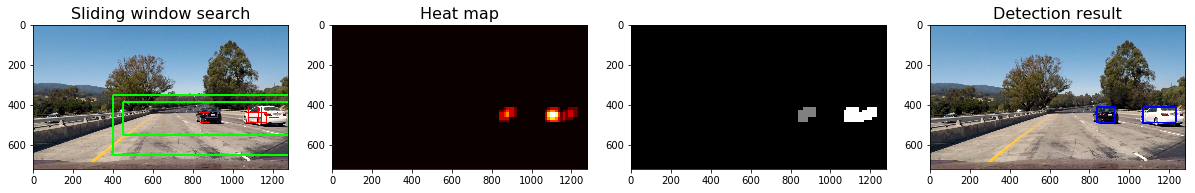

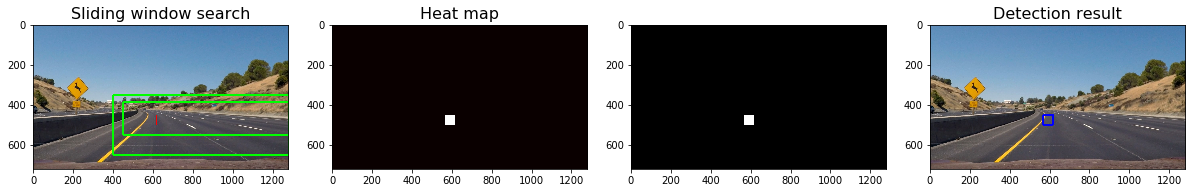

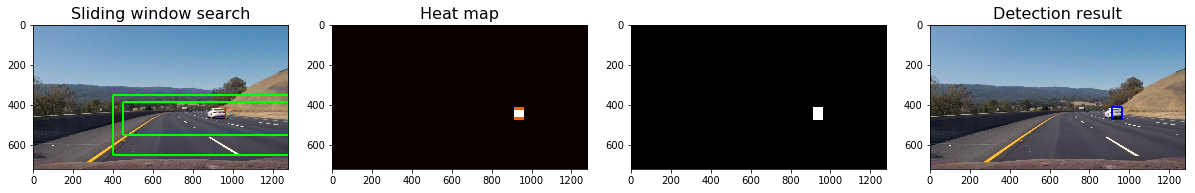

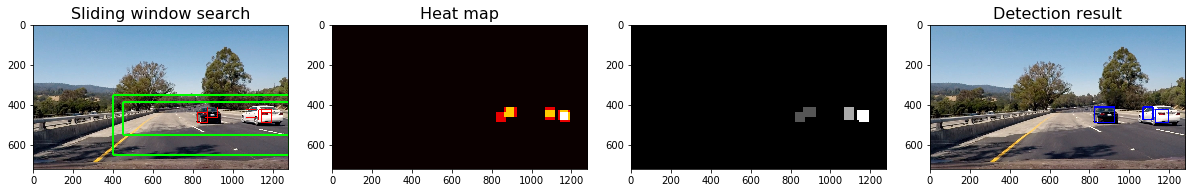

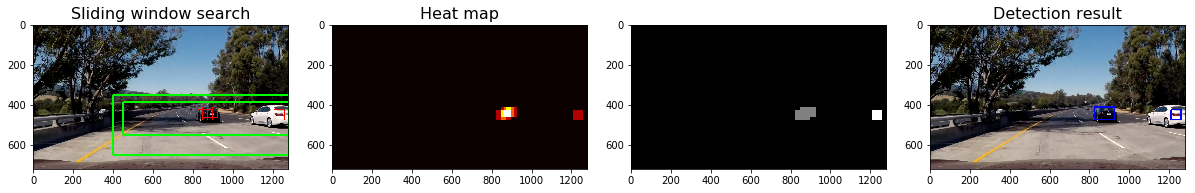

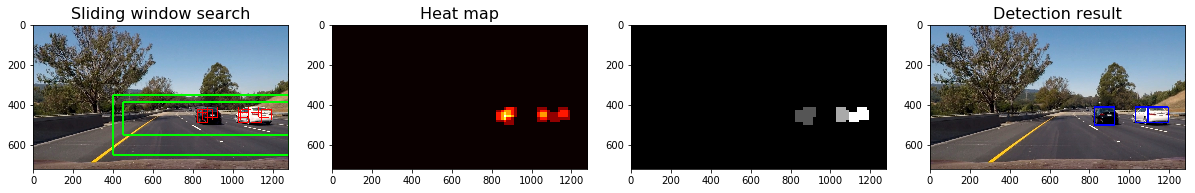

In [119]:
# Test pipelines for single image
i = 0
for img in imgTest:
    savePath = str('figures/pipeline' + str(i) + '.png')
    imgOut, heatMap, labels, imgDet = pipelineImage(img)
    plotPipeline(imgOut, heatMap, labels, imgDet, savePath)
    i += 1
    

### b. Eliminate false detection and smooth heat map

In [149]:
def heatMapSmooth(shape, boxes):
    global idxFrame, nFrame, heatMapArray
    # Single heatMap
    heatMapCur = np.zeros(shape)
    heatMapCur = createHeatMap(heatMapCur, boxes, opt)
    # Stack heatMap
    if idxFrame < nFrame:
        heatMapArray[:,:,idxFrame] = heatMapCur
        idxFrame += 1
    else:
        heatMapArray[:,:,0:nFrame - 2] = heatMapArray[:,:,1:nFrame - 1]
        heatMapArray[:,:,nFrame - 1] = heatMapCur
    # Smooth heatMap
    heatMapAvg = np.sum(heatMapArray, axis = 2)
    # Filter out false detection
    heatMapAvg[heatMapAvg <= opt['heatAvgTh']] = 0
    heatMapAvg = np.clip(heatMapAvg, 0 , 255)
    return heatMapAvg


In [150]:
# Define a helper function for processing video fram
def pipelineVideo(img):
    boxes = []
    # Collect positive detections
    for regionBound, boxScale in zip(regionBounds, boxScales):
        boxes = scanImg(img, regionBound, boxScale, X_scaler, clf, boxes, opt)
    # Draw boxes
#     img = drawBoxes(img, boxes, color=(255, 0, 0), thick=2)
    # Draw bounds
#     img = drawRegionBounds(img, regionBounds, color=(0, 255, 0), thick=2)
    # Generate heatMap
    heatMapAvg = heatMapSmooth(heatMap2DShape, boxes)
    # Draw detection
    labels = heatToDetection(heatMapAvg)
    imgDet = drawDetection(img, labels)
    return imgDet


### c. Test pipeline on video

In [185]:
# Initialize parameters
opt['heatAvgTh'] = 0.8
global idxFrame, nFrame, heatMapArray
idxFrame = 0
nFrame = 8
heatMap2DShape = [imgTest[0].shape[0],imgTest[0].shape[1]]
heatMap3DShape = [imgTest[0].shape[0],imgTest[0].shape[1],nFrame]

In [175]:
# Initialize parameters
heatMapArray = np.zeros(heatMap3DShape)

# Process short video clip
video1Out = 'output_videos/video1_out.mp4'
video1 = VideoFileClip('test_videos/video1.mp4')

video1Obj = video1.fl_image(pipelineVideo)
%time video1Obj.write_videofile(video1Out, audio=False)

[MoviePy] >>>> Building video output_videos/video1_out.mp4
[MoviePy] Writing video output_videos/video1_out.mp4


 97%|█████████▋| 38/39 [00:42<00:01,  1.22s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/video1_out.mp4 

CPU times: user 39.6 s, sys: 2.81 s, total: 42.4 s
Wall time: 44.7 s


In [176]:
# Initialize parameters
heatMapArray = np.zeros(heatMap3DShape)

# Process video clip
video3Out = 'output_videos/video3_out.mp4'
video3 = VideoFileClip('test_videos/video3.mp4')

video3Obj = video3.fl_image(pipelineVideo)
%time video3Obj.write_videofile(video3Out, audio=False)

[MoviePy] >>>> Building video output_videos/video3_out.mp4
[MoviePy] Writing video output_videos/video3_out.mp4


 97%|█████████▋| 32/33 [00:33<00:01,  1.01s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/video3_out.mp4 

CPU times: user 31.2 s, sys: 2.18 s, total: 33.4 s
Wall time: 34.6 s


In [179]:
# Initialize parameters
heatMapArray = np.zeros(heatMap3DShape)

# Process video clip
video4Out = 'output_videos/video4_out.mp4'
video4 = VideoFileClip('test_videos/video4.mp4')

video4Obj = video4.fl_image(pipelineVideo)
%time video4Obj.write_videofile(video4Out, audio=False)

[MoviePy] >>>> Building video output_videos/video4_out.mp4
[MoviePy] Writing video output_videos/video4_out.mp4


 99%|█████████▊| 72/73 [01:15<00:01,  1.04s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/video4_out.mp4 

CPU times: user 1min 10s, sys: 4.84 s, total: 1min 15s
Wall time: 1min 17s


In [182]:
# Initialize parameters
heatMapArray = np.zeros(heatMap3DShape)

# Process long video clip
videoBOut = 'output_videos/video2_out.mp4'
videoB = VideoFileClip('test_videos/video2.mp4')

videoBObj = videoB.fl_image(pipelineVideo)
%time videoBObj.write_videofile(videoBOut, audio=False)

[MoviePy] >>>> Building video output_videos/video2_out.mp4
[MoviePy] Writing video output_videos/video2_out.mp4


100%|█████████▉| 1260/1261 [21:50<00:01,  1.02s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/video2_out.mp4 

CPU times: user 20min 26s, sys: 1min 28s, total: 21min 54s
Wall time: 21min 52s
